In [199]:
import pandas as pd

#definição do caminho até o arquivo
file_name = 'datas/FEM_T2_AC.csv'

#tentativa de leitura desse arquivo
try:
    #armazenamos a leitura dos dados do arquivo na variável 'datas'
    #o arquivo .csv nãa tem o header, por isso do 'header=None'
    datas = pd.read_csv(file_name, header=None)

    #criação de um nome para as colunas, sendo a primeira 'Time' e a segunda 'Signal'
    datas.columns = ['Time', 'Signal']

    #verificação para ver os 5 primeiros dados
    print(datas.head())

#caso não consiga acessar o arquivo
except FileNotFoundError:
    print(f"ERRO: O arquivo em '{file_name}' não foi encontrado!")

       Time    Signal
0  0.000977  0.985451
1  0.001953  0.971115
2  0.002930  0.957016
3  0.003906  0.943194
4  0.004883  0.929659


In [200]:
import numpy as np

#ruido (desvio padrão) definido como 0.1
standard_deviation = 0.1

#criação da variável 'noise' que armazena um vetor até de tamanho 'len(datas'
#valores que estão distribuidos de forma normal com média centrada no 0 e desvio padrão de 0.1
noise = np.random.normal(0, standard_deviation, len(datas))

#criação de uma coluna com esses dados alterados
datas['Signal_Noisy'] = datas['Signal'] + noise

#verificação para ver os 5 primeiros dados
print(datas.head())


       Time    Signal  Signal_Noisy
0  0.000977  0.985451      0.864134
1  0.001953  0.971115      1.039120
2  0.002930  0.957016      1.104803
3  0.003906  0.943194      1.083894
4  0.004883  0.929659      0.836180


In [201]:
#variável que recebe o tamanho de 'datas'
N = len(datas)

#variável que armazena um vetor de valores de maneira permutada de tamanho N
shuffler = np.random.permutation(N)

#criação de uma variável com os dados rearranjados, mas o indice continua bagunçado
datas_shuffled = datas.iloc[shuffler]

#verificação para ver os 5 primeiros dados dessa nova variável com os indices bagunçados
print(datas_shuffled.head())
print(f'\n')

#agora atualizamos o índice para manter o bom andamento do código
datas_shuffled = datas_shuffled.reset_index(drop = True)

#verificação para ver os 5 primeiros dados dessa nova variável com os indices atualizados
print(datas_shuffled.head())

          Time        Signal  Signal_Noisy
3465  3.384766  1.680049e-07      0.042670
1082  1.057617  1.451747e-03      0.176364
3226  3.151367  3.981637e-07     -0.058287
1078  1.053711  1.477027e-03      0.063344
615   0.601562  1.253330e-02     -0.002671


       Time        Signal  Signal_Noisy
0  3.384766  1.680049e-07      0.042670
1  1.057617  1.451747e-03      0.176364
2  3.151367  3.981637e-07     -0.058287
3  1.053711  1.477027e-03      0.063344
4  0.601562  1.253330e-02     -0.002671


In [202]:
from sklearn.model_selection import train_test_split

#criação do X e do y para fazermos os testes
#é necessário o uso de '[[]]' no X por conta do formato que o scikit-leatn foi projetada
X = datas_shuffled[['Time']]
y = datas_shuffled['Signal_Noisy']

#divisão dos dados para treinos e testes, utilizando de 20% dos dados para testes
#a utilização do 'random_state = 42' é uma convenção, é necessário utilizar para mantermos uma consistência 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#verificação para ver a forma dos dados de treino e teste 
print(f"X_train = {X_train.shape}")
print(f"X_test = {X_test.shape}")
print(f"y_train = {y_train.shape}")
print(f"y_test = {y_test.shape}")


X_train = (3276, 1)
X_test = (820, 1)
y_train = (3276,)
y_test = (820,)


Como funciona a regularização Ridge nesse contexto:

Nossa função analizada de magnetização é definida pela função:
$$
\tilde{M}(t) = \frac{\int_{\Omega} \tilde{m}(\mathbf{r}, t) d\Omega}{\int_{\Omega} 1 d\Omega} \quad \text{ou} \quad M(t) = \frac{\int_{\Omega} m(\mathbf{r}, t) d\Omega}{\int_{\Omega} 1 d\Omega}
$$
Mas podemos também representa-la como sendo uma séria de produtos de funções Fi(r)Gi(t), a parte do tempo pode ser descrita como exp(-(1/Tb + 1/Ti)t) sendo:
$$
\begin{gathered}
\text{Tb: a relaxação de "bulk"} \\
\text{Ti: a relaxação de superfície}
\end{gathered}
$$
porém no artigo Large Scale Voxel‑Based FEM Formulation for NMR Relaxation in Porous Media temos um estudo completo demonstrando que podemos tratar essa relaxação de bilk como se fosse infinito, reduzindo nossa função para exp(-t/Ti).
Temos ainda a função Fi(r) como sendo uma soma até infinito de integrais, mas podemos definir isso como c, e desse jeito, conseguimos pela regularização Ridge através dos dados e da função Gi(t) achar o melhor c. Logo abaixo verificamos isso sendo feito na prática.

In [203]:
from sklearn.linear_model import Ridge

#criando candidatos se baseando no artigo. De 10^-3 até 10^1 com 256 pontos espaçados igualmente na escala logarítmica
t2_candidates = np.logspace(-3, 1, 256)

#atribuindo os valores de X_train a t_train, mudando o formato para podermos fazermos os cálculos
t_train = X_train['Time'].values.reshape(-1,1)

#criando a matriz (kernel), onde cada célula (i, j) contém o valor de exp(-t_train[i] / t2_candidates[j])
matrix = np.exp(-t_train/t2_candidates)

#utilizamos regularização Ridge com valor de alpha (lambda) como 0.1 e definindo os valores como sendo positivo
ridge = Ridge(alpha = 0.1, positive = True)

#essa função calcula a minimização para encontrar o melhor vetor 'c'
ridge.fit(matrix, y_train)

#pegamos os valores obtidos e armazenamos em 't2_distribution'
t2_distribution = ridge.coef_

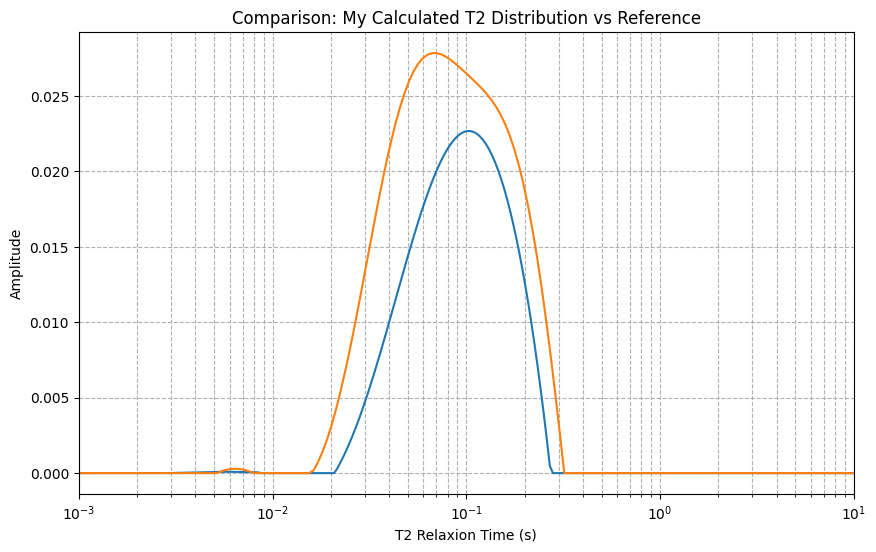

In [204]:
import matplotlib.pyplot as plt

#agora precisamos do arquivo referência para fazermos a comparação
file_name = 'datas/FEM_AC_INV.csv'

#tentativa de leitura desse arquivo
try:
    #leitura do arquivo referência
    datas_inv = pd.read_csv(file_name, header=None)

    #criação de um nome para as colunas, sendo a primeira 'Time_ref' e a segunda 'Amplitude_ref'
    datas_inv.columns = ['Time_ref', 'Amplitude_ref']

    #gerando o gráfico
    plt.figure(figsize=(10,6))
    plt.plot(t2_candidates, t2_distribution, label="My Ridge Regression")
    plt.plot(datas_inv['Time_ref'], datas_inv['Amplitude_ref'], label="Reference")
    plt.xscale("log")
    plt.title("Comparison: My Calculated T2 Distribution vs Reference")
    plt.xlabel("T2 Relaxion Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, which="both", ls="--")
    plt.xlim(10**-3, 10**1)
    plt.show()

#caso não consigo abrir o arquivo
except FileNotFoundError:
    print(f"ERRO: O arquivo em '{file_name}' não foi encontrado!")